<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EA%B9%80%EC%A7%84%EA%B7%BC/LSTM_%ED%95%9C%EB%B2%88%EC%97%90_%ED%95%98%EB%82%98%EC%94%A9_%ED%94%BC%EC%B3%903%EA%B0%9C_%EC%98%A4%EC%B0%A8%EC%9C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers.core import Activation, Dense, Dropout
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [41]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [43]:
df = df[['Resistance', 'Volt', 'Temp']]
df

,Resistance,Volt,Temp
0,0.296,2.25,-20
1,0.297,2.25,-20
2,0.298,2.25,-20
3,0.298,2.25,-20
4,0.296,2.25,-20
...,...,...,...
250,0.619,2.29,-20
251,0.620,2.30,-20
252,0.623,2.30,-20
253,0.639,2.30,-20


In [44]:
n_samples = len(df)

In [45]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance', 'Volt', 'Temp']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled_train = df_scaled.loc[:,]
df_scaled_train.columns = scale_cols


In [47]:
train_sc_df = pd.DataFrame(df_scaled_train, columns=['Resistance', 'Volt', 'Temp'], index=df_scaled_train.index)
train_sc_df

,Resistance,Volt,Temp
0,0.000000,0.0,0.0
1,0.002915,0.0,0.0
2,0.005831,0.0,0.0
3,0.005831,0.0,0.0
4,0.000000,0.0,0.0
...,...,...,...
250,0.941691,0.8,0.0
251,0.944606,1.0,0.0
252,0.953353,1.0,0.0
253,1.000000,1.0,0.0


In [48]:
train_feature = train_sc_df[['Resistance', 'Volt', 'Temp']]
train_label = train_sc_df[['Resistance', 'Volt', 'Temp']]

In [49]:
train_feature, train_label = make_dataset(train_feature, train_label, 50)

In [50]:
train_feature = train_feature.reshape(train_feature.shape[0], train_feature.shape[1], -1)

In [51]:
train_label = train_label.reshape(train_label.shape[0], -1)


In [52]:
train_feature.shape, train_label.shape

((205, 50, 3), (205, 3))

In [53]:
train_feature, train_label

(array([[[0.        , 0.        , 0.        ],
         [0.00291545, 0.        , 0.        ],
         [0.0058309 , 0.        , 0.        ],
         ...,
         [0.06413994, 0.        , 0.        ],
         [0.06413994, 0.        , 0.        ],
         [0.06705539, 0.        , 0.        ]],
 
        [[0.00291545, 0.        , 0.        ],
         [0.0058309 , 0.        , 0.        ],
         [0.0058309 , 0.        , 0.        ],
         ...,
         [0.06413994, 0.        , 0.        ],
         [0.06705539, 0.        , 0.        ],
         [0.06413994, 0.2       , 0.        ]],
 
        [[0.0058309 , 0.        , 0.        ],
         [0.0058309 , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.06705539, 0.        , 0.        ],
         [0.06413994, 0.2       , 0.        ],
         [0.06413994, 0.2       , 0.        ]],
 
        ...,
 
        [[0.55102041, 0.4       , 0.        ],
         [0.55102041, 0.4       , 0.     

In [54]:
model = Sequential()
model.add(LSTM(128, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu')
          )
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(3))

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 78,019
Trainable params: 78,019
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
h = model.fit(train_feature, train_label, 
                    epochs=100, 
                    batch_size=1, verbose=2)

Epoch 1/100
205/205 - 4s - loss: 0.0035 - mse: 0.0035
Epoch 2/100
205/205 - 2s - loss: 0.0017 - mse: 0.0017
Epoch 3/100
205/205 - 2s - loss: 0.0016 - mse: 0.0016
Epoch 4/100
205/205 - 2s - loss: 0.0010 - mse: 0.0010
Epoch 5/100
205/205 - 2s - loss: 0.0012 - mse: 0.0012
Epoch 6/100
205/205 - 2s - loss: 9.3346e-04 - mse: 9.3346e-04
Epoch 7/100
205/205 - 2s - loss: 0.0010 - mse: 0.0010
Epoch 8/100
205/205 - 2s - loss: 0.0010 - mse: 0.0010
Epoch 9/100
205/205 - 2s - loss: 0.0017 - mse: 0.0017
Epoch 10/100
205/205 - 2s - loss: 9.3280e-04 - mse: 9.3280e-04
Epoch 11/100
205/205 - 2s - loss: 7.5327e-04 - mse: 7.5327e-04
Epoch 12/100
205/205 - 2s - loss: 7.8359e-04 - mse: 7.8359e-04
Epoch 13/100
205/205 - 2s - loss: 7.6011e-04 - mse: 7.6011e-04
Epoch 14/100
205/205 - 2s - loss: 7.7381e-04 - mse: 7.7381e-04
Epoch 15/100
205/205 - 2s - loss: 8.2802e-04 - mse: 8.2802e-04
Epoch 16/100
205/205 - 2s - loss: 0.0010 - mse: 0.0010
Epoch 17/100
205/205 - 2s - loss: 8.4846e-04 - mse: 8.4846e-04
Epoch 18/1

[0.78143883 0.79586518 0.80539691 0.8149085  0.82448816 0.83412969
 0.84385073 0.8536669  0.863644   0.87378943 0.88415313 0.89477825
 0.90568233 0.91689408 0.92845356 0.94037366 0.95267427 0.96539402
 0.97857451 0.99222696]


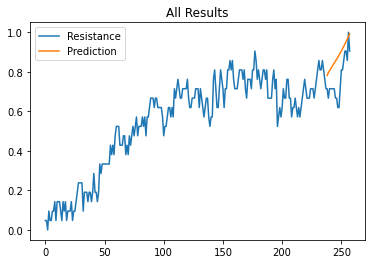

avg =  13.83200045100261


In [57]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

test_df = test_df[['Resistance', 'Volt', 'Temp']]
lengh = len(test_df)-20
test = test_df.loc[:lengh,]
scale_cols = ['Resistance', 'Volt', 'Temp']

scaler = MinMaxScaler()
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols

df_scaled_test = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled_test, columns=['Resistance', 'Volt', 'Temp'])
df_scaled_test_pre = df_scaled.loc[:lengh,]
# df_scaled_test = df_scaled
df_scaled_test_pre.columns = scale_cols

test_sc_df = pd.DataFrame(df_scaled_test_pre, columns=['Resistance', 'Volt', 'Temp'], index=df_scaled_test_pre.index)

test_feature = test_sc_df[['Resistance', 'Volt', 'Temp']]
test_label = test_sc_df[['Resistance', 'Volt', 'Temp']]

test_feature, test_label = make_dataset(test_feature, test_label, 50)
test_feature = test_feature.reshape(test_feature.shape[0], test_feature.shape[1], -1)
test_label = test_label.reshape(test_label.shape[0], -1)

# xhat = test_feature[len(test_feature)-1]
# pred = model.predict(np.array([xhat]), batch_size=16)
# print(pred[:, 0])
# print(test_label[len(test_label)-1])

# pred = model.predict(test_feature)
# print(pred)
# print(test_label)
# plt.plot(pred)
# plt.plot(test_label)
# plt.show()


all_lengh = 20
xhat = test_feature[len(test_feature)-1]
predictions = np.zeros(all_lengh)
  #print(xhat)
#prediction = model.predict(np.array([xhat]), batch_size=16)
#print(prediction)

for i in range(all_lengh):
    prediction = model.predict(np.array([xhat]), batch_size=16)
#   # print("1", prediction)
    predictions[i] = prediction[:, 0]
#   # print("2",predictions)
    xhat=np.vstack([xhat[1:],prediction])
print(predictions)


resistance = df_scaled['Resistance']
#print(resistance)
resistance.plot()
x_list = [] 
for i in range(lengh, lengh+20):

  x_list.append(np.array(i))
plt.plot(x_list, predictions, label='Prediction')
plt.legend(loc=0)
plt.title('All Results')
plt.show()

# mae = tf.keras.losses.mean_absolute_error(label_list, predictions)
# print("MAE = ", mae)
# mse = tf.keras.losses.mean_squared_error(label_list, predictions)
# print("MSE = ", mse)

error_avg = 0
error = 0
label_list = resistance[len(resistance)-20:].values
for i in range(20):
  error = abs(((predictions[i]-label_list[i]) / predictions[i]) * 100)
  error_avg += error
print("avg = ", error_avg/20)

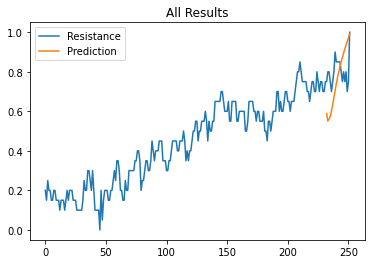

MAE =  tf.Tensor(0.08607328420593596, shape=(), dtype=float64)
MSE =  tf.Tensor(0.009724692965670046, shape=(), dtype=float64)
avg =  18.78408810134387


In [58]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df[['Resistance', 'Volt', 'Temp']]
lengh = len(test_df)-20
test = test_df.loc[:lengh,]
scale_cols = ['Resistance', 'Volt', 'Temp']

scaler = MinMaxScaler()
test_df = pd.DataFrame(test_df)
test_df.columns = scale_cols

df_scaled_test = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled_test, columns=['Resistance', 'Volt', 'Temp'])
df_scaled_test_pre = df_scaled.loc[:lengh,]
# df_scaled_test = df_scaled
df_scaled_test_pre.columns = scale_cols

test_sc_df = pd.DataFrame(df_scaled_test_pre, columns=['Resistance', 'Volt', 'Temp'], index=df_scaled_test_pre.index)

test_feature = test_sc_df[['Resistance', 'Volt', 'Temp']]
test_label = test_sc_df[['Resistance', 'Volt', 'Temp']]

test_feature, test_label = make_dataset(test_feature, test_label, 50)
test_feature = test_feature.reshape(test_feature.shape[0], test_feature.shape[1], -1)
test_label = test_label.reshape(test_label.shape[0], -1)

# xhat = test_feature[len(test_feature)-1]
# pred = model.predict(np.array([xhat]), batch_size=16)
# print(pred[:, 0])
# print(test_label[len(test_label)-1])

# pred = model.predict(test_feature)
# print(pred)
# print(test_label)
# plt.plot(pred)
# plt.plot(test_label)
# plt.show()


all_lengh = 20
xhat = test_feature[len(test_feature)-1]
predictions = np.zeros(all_lengh)

for i in range(all_lengh):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  # print("1", prediction)
  predictions[i] = prediction[:, 0]
  # print("2",predictions)
  xhat=np.vstack([xhat[1:],prediction])
# print(predictions)


resistance = df_scaled['Resistance']
resistance.plot()
x_list = [] 
for i in range(lengh, lengh+20):
     x_list.append(np.array(i))
plt.plot(x_list, predictions, label='Prediction')
plt.legend(loc=0)
plt.title('All Results')
plt.show()

mae = tf.keras.losses.mean_absolute_error(label_list, predictions)
print("MAE = ", mae)
mse = tf.keras.losses.mean_squared_error(label_list, predictions)
print("MSE = ", mse)

error_avg = 0
error = 0
label_list = resistance[len(resistance)-20:].values
for i in range(20):
    error = abs(((predictions[i]-label_list[i]) / predictions[i]) * 100)
    error_avg += error
print("avg = ", error_avg/20)